# 10% Labeled Semi-supervised image classification using contrastive pretraining with SimCLR

In [9]:
import os
import sys
import math
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Algorithm hyperparameters
num_epochs = 100
image_channels = 3

width = 128 # number of classes that can be detected
temperature = 0.1

seed = 42
val_split   = 0.2
batch_size = 64
image_size = 224

#stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

In [11]:
test_path = "../Data/OCT2017 /test/"
valid_path = "../OCT2017 /val/"
unlab_train_path = "../Data/OCT2017_RAW/train/"
lab_train_path = "../Data/OCT2017 /10%_train/"

Used 20% of the labeled data for validation set. 
Set the labels as None for the entire dataset to be considered as unlabeled. 

In [12]:
def prepare_dataset():
      
    unlab_train_ds = (tf.keras.utils.image_dataset_from_directory(
        unlab_train_path,
        batch_size=batch_size,
        image_size= (image_size, image_size),
        labels = None
    ))
    
    lab_train_ds = (tf.keras.utils.image_dataset_from_directory(
        lab_train_path,
        batch_size=batch_size,
        image_size=(image_size, image_size),
        seed=seed,
        validation_split=val_split,
        subset='training',
    ))
   
    test_ds = (tf.keras.utils.image_dataset_from_directory(
        lab_train_path,
        batch_size=batch_size,
        image_size=(image_size, image_size),
        seed=seed,
        validation_split=val_split,
        subset='validation',
        ))
    
    train_dataset = tf.data.Dataset.zip((unlab_train_ds, lab_train_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return train_dataset, lab_train_ds, test_ds


# Load dataset
train_dataset, labeled_train_dataset, test_dataset = prepare_dataset()

Found 83484 files belonging to 1 classes.
Found 8346 files belonging to 4 classes.
Using 6677 files for training.
Found 8346 files belonging to 4 classes.
Using 1669 files for validation.


### Image Augmentations

Two most important for contrastive learning are Cropping and Color Jitter.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


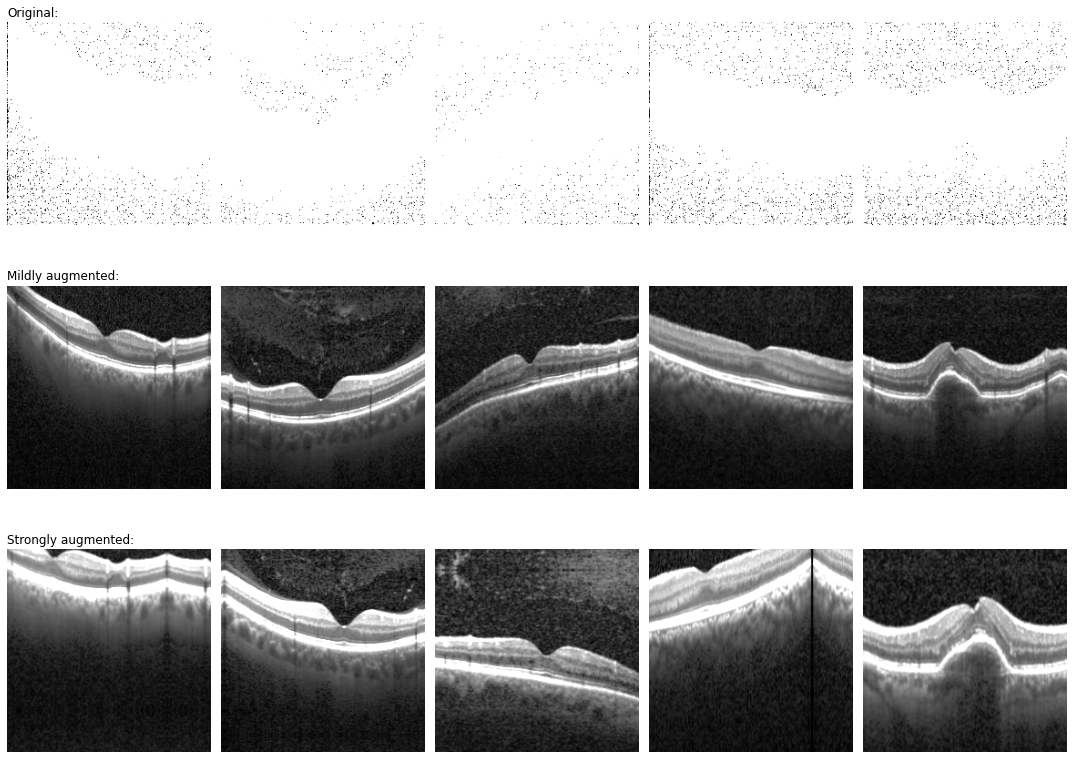

In [13]:
# Distorts the color distributions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter = 0, **kwargs):
        super().__init__(**kwargs)
        
        self.brightness = brightness
        self.jitter = jitter
        
    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config
    
    def call(self, images, training = True):
        if training:
            batch_size = tf.shape(images)[0]
            
            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
            (batch_size, 1,1,1), minval = self.brightness, maxval = self.brightness
            )
            
            # Different for all colors
            jitter_matrices = tf.random.uniform(
            (batch_size, 1, 3, 3), minval = self.jitter, maxval = self.jitter
            )
            
            color_transforms = (
            tf.eye(3, batch_shape = [batch_size, 1]) * brightness_scales + jitter_matrices
            )
            
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images

# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    
    return keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        layers.Rescaling(1 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
        layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
        RandomColorAffine(brightness, jitter)
    ])

def visualize_augmentations(num_images):
    # sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]

    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Mildly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize = (15,15))
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc = "left")
            plt.axis("off")
    plt.tight_layout()
    
visualize_augmentations(num_images = 5)

### Basemodel (Encoder) Architecture

In [15]:
def create_basemodel(resnet, 
                     input_shape,
                     dataset,
                     width,
                     n_classes):
    
    image_batch, _ = next(iter(dataset)) # extract 1 batch from the dataset
    feature_batch = resnet(image_batch)
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None)
    base_model.trainable = True
    
    inputs = tf.keras.layers.Input(shape = (image_size, image_size, image_channels))
    pool = tf.keras.layers.GlobalAveragePooling2D()
    relu = tf.keras.layers.Dense(width, activation='relu')
    
    x = inputs
    x = base_model(x)
    x = pool(x)
    out = relu(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

In [16]:
n_classes = 4

resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                            weights=None, 
                                            input_shape = (image_size, image_size, image_channels))

create_basemodel(resnet50,(image_size,image_size,image_channels),labeled_train_dataset,width,n_classes).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________


### Supervised baseline model

In [17]:
# Baseline supervised training with random initialization
n_classes = 4

baseline_model = keras.Sequential([
    keras.Input(shape = (image_size, image_size, image_channels)),
    get_augmenter(**classification_augmentation),
    create_basemodel(resnet50, (image_size, image_size, image_channels), labeled_train_dataset, width,n_classes),
    layers.Dense(n_classes)
],name = "baseline_model"
)

metrics = ['accuracy']
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='../Models/10%_aug_supervised_model_bs64.{epoch:02d}-{val_loss:.2f}.h5',
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True),

]
optimizer = tf.keras.optimizers.Adam()

baseline_model.compile(
    optimizer = optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = metrics,
)

In [18]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_1 (Functional)        (None, 128)               23849984  
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23,850,500
Trainable params: 23,797,380
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
baseline_history = baseline_model.fit(
    labeled_train_dataset, 
    epochs = num_epochs, 
    validation_data = test_dataset,
    callbacks = callbacks,
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/100
105/105 [==============================] - 184s 2s/step - loss: 1.0855 - accuracy: 0.6407 - val_loss: 3.1136 - val_accuracy: 0.4446
Epoch 2/100
105/105 [==============================] - 177s 2s/step - loss: 0.6533 - accuracy: 0.7623 - val_loss: 2.1366 - val_accuracy: 0.3673
Epoch 3/100
105/105 [==============================] - 177s 2s/step - loss: 0.5518 - accuracy: 0.8041 - val_loss: 3.4470 - val_accuracy: 0.3050
Epoch 4/100
105/105 [==============================] - 177s 2s/step - loss: 0.4339 - accuracy: 0.8462 - val_loss: 0.9516 - val_accuracy: 0.6980
Epoch 5/100
105/105 [==============================] - 177s 2s/step - loss: 0.3949 - accuracy: 0.8648 - val_loss: 2.1784 - val_accuracy: 0.5075
Epoch 6/100
105/105 [==============================] - 177s 2s/step - loss: 0.3419 - accuracy: 0.8832 - val_loss: 0.8425 - val_accuracy: 0.7184
Epoch 7/100
105/105 [==============================] - 177s 2s/step - loss: 0.2992 - accuracy: 0.9001 - val_loss: 1.3883 - val_accuracy:

The baseline model was able to achieve **93.05%** validation accuracy after 100 epochs with 10% labeled dataset.

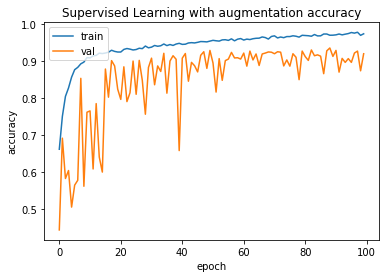

In [35]:
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['val_accuracy'])
plt.title('Supervised Learning with augmentation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
test_batch = tf.keras.utils.image_dataset_from_directory(test_path,
                                                         image_size=(image_size, image_size),
                                                         shuffle=False,
                                                         batch_size = 1,
                                                         seed=seed,)

Found 968 files belonging to 4 classes.


In [22]:
baseline_model.load_weights('../Models/10%_aug_supervised_model_bs64.43-0.23.h5')

In [23]:
baseline_model.evaluate(test_batch)

968/968 [==============================] - 29s 30ms/step - loss: 0.0748 - accuracy: 0.9752


[0.0748191624879837, 0.9752066135406494]

Augmented supervised learning model on 10% labeled data achieved 97.5% test accuracy. 

### Self-supervised model for contrastive pretraining

Pretrain the encoder on unlabeled images with a contrastive loss. A nonlinear projection head is attached to the top of the encoder, as it improve the quality of representations of the encoder.

In [24]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder =  create_basemodel(resnet50, (image_size, image_size, image_channels), labeled_train_dataset, width,4)
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(4)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(name="c_acc")
        
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        """These are metrics we want to print and carry through our gradient tape"""
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        unlabeled_images, (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}

In [25]:
# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,849,984
Trainable params: 23,796,864
Non-trainable params: 53,120
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)    

In [26]:
callbacks2 = [
tf.keras.callbacks.ModelCheckpoint(filepath='../Models/pretraining_model.{epoch:02d}-{val_p_loss:.2f}.h5',
                                                monitor='val_accuracy',
                                                mode='max',
                                                save_best_only=True),

]


pretraining_history = pretraining_model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset,
    callbacks = callbacks2
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Epoch 1/100
105/105 [==============================] - 588s 5s/step - c_loss: 3.4199 - c_acc: 0.1704 - p_loss: 2.3603 - p_acc: 0.3382 - val_p_loss: 2.8795 - val_p_acc: 0.3158
Epoch 2/100
105/105 [==============================] - 574s 5s/step - c_loss: 1.8649 - c_acc: 0.5156 - p_loss: 2.8753 - p_acc: 0.3620 - val_p_loss: 1.4428 - val_p_acc: 0.3661
Epoch 3/100
105/105 [==============================] - 573s 5s/step - c_loss: 1.1894 - c_acc: 0.6962 - p_loss: 2.5030 - p_acc: 0.4063 - val_p_loss: 2.4245 - val_p_acc: 0.4332
Epoch 4/100
105/105 [==============================] - 574s 5s/step - c_loss: 0.9081 - c_acc: 0.7812 - p_loss: 3.7536 - p_acc: 0.3897 - val_p_loss: 2.3216 - val_p_acc: 0.1977
Epoch 5/100
105/105 [==============================] - 572s 5s/step - c_loss: 0.7506 - c_acc: 0.8298 - p_loss: 1.9279 - p_acc: 0.4418 - val_p_loss: 2.6087 - val_p_acc: 0.2852
Epoch 6/100
105/105 [==============================] - 572s 5s/step - c_loss: 0.6409 - c_acc: 0.8609 - p_loss: 1.8158 - p_acc

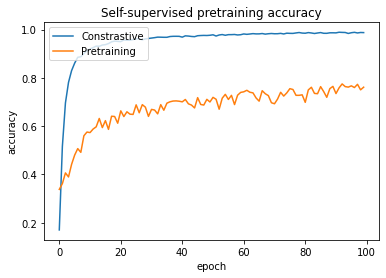

In [27]:
plt.plot(pretraining_history.history['c_acc'])
plt.plot(pretraining_history.history['p_acc'])
plt.title('Self-supervised pretraining accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Constrastive', 'Pretraining'], loc='upper left')
plt.show()

In [28]:
baseline_model.save("../Models/keras_simclr_pretrain_full_bs64_70.64%.h5")

Pretraining with accuracy of 70.64% was achieved with 10% labeled data. Low accuracy during pretraining is expected. 

### Supervised finetuning of the pretrained encoder

In [29]:
# Supervised finetuning of the pretrained encoder - Student Net
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(4),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

callbacks3 = [tf.keras.callbacks.ModelCheckpoint(filepath='../Models/keras_simclr_semi_supervised_model.{epoch:02d}-{val_loss:.2f}.h5',
                                                monitor='val_acc',
                                                mode='max',
                                                save_best_only=True),

]

finetuning_history = finetuning_model.fit(
    labeled_train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset,
    callbacks = callbacks3
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

Epoch 1/100
105/105 [==============================] - 182s 2s/step - loss: 1.1665 - acc: 0.7622 - val_loss: 4.7513 - val_acc: 0.3673
Epoch 2/100
105/105 [==============================] - 177s 2s/step - loss: 0.3770 - acc: 0.8684 - val_loss: 0.8982 - val_acc: 0.7370
Epoch 3/100
105/105 [==============================] - 177s 2s/step - loss: 0.2777 - acc: 0.9038 - val_loss: 0.6423 - val_acc: 0.8047
Epoch 4/100
105/105 [==============================] - 176s 2s/step - loss: 0.2486 - acc: 0.9122 - val_loss: 0.8069 - val_acc: 0.7579
Epoch 5/100
105/105 [==============================] - 177s 2s/step - loss: 0.2120 - acc: 0.9265 - val_loss: 0.5098 - val_acc: 0.8155
Epoch 6/100
105/105 [==============================] - 177s 2s/step - loss: 0.2024 - acc: 0.9296 - val_loss: 0.5122 - val_acc: 0.8406
Epoch 7/100
105/105 [==============================] - 177s 2s/step - loss: 0.1993 - acc: 0.9289 - val_loss: 0.3961 - val_acc: 0.8676
Epoch 8/100
105/105 [==============================] - 176s 2s

Semi-supervised learning model on 10% labeled data achieved 93.23 validation accuracy.

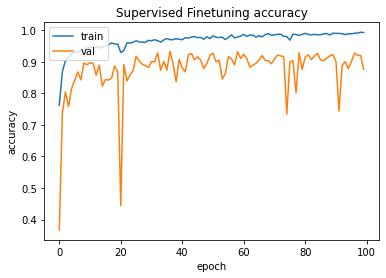

In [30]:
plt.plot(finetuning_history.history['acc'])
plt.plot(finetuning_history.history['val_acc'])
plt.title('Supervised Finetuning accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
finetuning_model.load_weights('../Models/10%_simclr_semi_supervised_model_bs64.33-0.27.h5')

In [33]:
finetuning_model.evaluate(test_batch)

968/968 [==============================] - 29s 30ms/step - loss: 0.0896 - acc: 0.9711


[0.08955220133066177, 0.9710744023323059]

Semi-supervised learning model on 10% labeled data achieved 97.10% test accuracy.

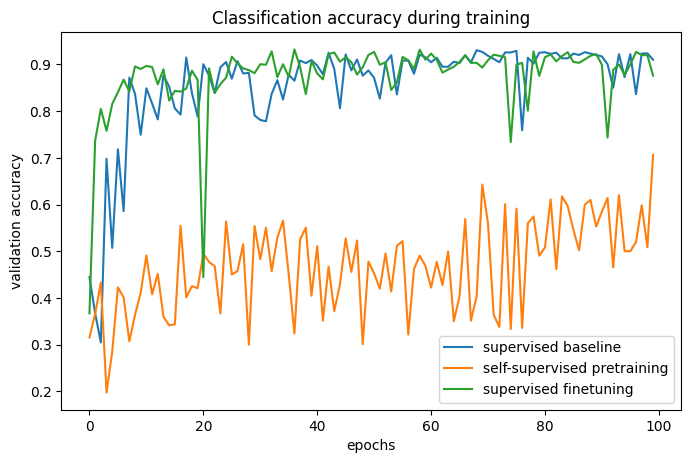

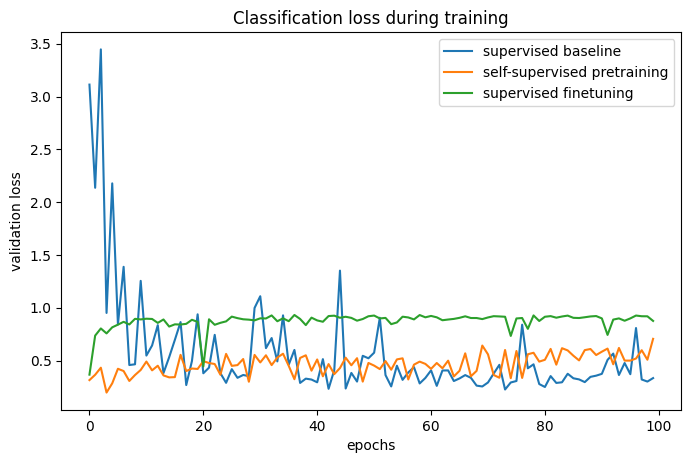

In [34]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["accuracy", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_acc"],

            #pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_acc"],
            #finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

# Acknowledgement & Reference

- simCLR model was adapted from [keras.io](https://keras.io/examples/vision/semisupervised_simclr/)